In [1]:
import torch
from tqdm import tqdm
from torch import nn, optim
from torch.nn import init
import pandas as pd
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("../../data2/data.csv").drop(columns = ["id", "source", 
                                                       "latitude", "longitude", 
                                                           "L_clinic", "L_place_of_worship",
                                                           "L_hospital", "L_kindergarten",
                                                           "SL_baghramyan_subway"])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850 entries, 0 to 1849
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         1850 non-null   int64  
 1   price                              1850 non-null   float64
 2   area                               1850 non-null   float64
 3   rooms                              1850 non-null   float64
 4   floor                              1850 non-null   float64
 5   storeys                            1850 non-null   float64
 6   bathroom_count                     1850 non-null   float64
 7   new_building                       1850 non-null   int64  
 8   F_Balcony                          1850 non-null   int64  
 9   F_Internet                         1850 non-null   int64  
 10  F_Security                         1850 non-null   int64  
 11  F_Elevator                         1850 non-null   int64

In [2]:
class TabularFFNNSimple(nn.Module):
    def __init__(self, input_size, output_size, dropout_prob=0.4):
        super(TabularFFNNSimple, self).__init__()
        hidden_size = 38
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.25),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.18),
            nn.Linear(hidden_size, output_size)
        )
        
        for m in self.ffnn:
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0)

    def forward(self, x):
        x = x.float()
        # print(x)
        x = x.view(x.size(0), -1)
        x = self.ffnn(x)
        return x
    
# Split the data into features and target
X = data.drop('price', axis=1)
y = data['price']

# Standardize the features
device = torch.device("cpu")
# Convert to PyTorch tensors
X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


# Split the data into training and combined validation and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor,
                                                            test_size=0.4, random_state=42)

# Split the combined validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Create DataLoader for training, validation, and testing
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 512
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Check if the dimensions match the expected input size for the model
input_size = X_train.shape[1]

# Output
# input_size, train_loader, test_loader

model = TabularFFNNSimple(
    input_size = input_size,
    output_size = 1
)
model.to(device)

num_epochs = 300000
train_losses = []
val_losses = []
epochs_suc = [] # to have a reference to it
grad_norms = []

def get_gradient_norm(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

In [ ]:
optimizer = optim.Adam(
    model.parameters(), 
    lr=1e-3,
    weight_decay=3e-4
)
criterion = torch.nn.MSELoss()
criterion_abs = torch.nn.L1Loss()
criterion = criterion_abs

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.999, 
    patience=100, 
    verbose=True
)

for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    running_loss = 0.0
    l1_losses = []
    grad_norm = 0
    for tuple_ in train_loader:
        datas, prices = tuple_
        optimizer.zero_grad()
        outputs = model(datas)
        prices_viewed = prices.view(-1, 1).float()
        loss = criterion(outputs, prices_viewed)
        loss.backward()
        grad_norm += get_gradient_norm(model)
        optimizer.step()

        running_loss += loss.item()
        
    grad_norms.append(grad_norm / len(train_loader))
    train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for tuple_ in val_loader:
            datas, prices = tuple_
            outputs = model(datas)  # Forward pass
            prices_viewed = prices.view(-1, 1).float()
            loss = criterion(outputs, prices_viewed)  # Compute loss
            val_loss += loss.item()  # Accumulate the loss
            l1_losses.append(criterion_abs(outputs, prices_viewed))

    val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
    l1_mean_loss = sum(l1_losses) / len(l1_losses)
    # Print epoch's summary
    epochs_suc.append(epoch)
#     scheduler.step(val_losses[-1])
    if epoch % 100 == 0:
        tl = f"Training Loss: {int(train_losses[-1])}"
        vl = f"Validation Loss: {int(val_losses[-1])}"
        l1 = f"L1: {int(l1_mean_loss)}"
        dl = f'Epoch {epoch+1}, {tl}, {vl}, {grad_norms[-1]}'
        print(dl)

Epoch 1, Training Loss: 40873, Validation Loss: 55250, 43881.01812298637
Epoch 101, Training Loss: 41770, Validation Loss: 52374, 54903.14687717877
Epoch 201, Training Loss: 39315, Validation Loss: 52437, 46666.86084051796
Epoch 301, Training Loss: 39924, Validation Loss: 51639, 65471.4257335229
Epoch 401, Training Loss: 41900, Validation Loss: 52806, 54478.88132301194
Epoch 501, Training Loss: 41906, Validation Loss: 52206, 49472.67279412418
Epoch 601, Training Loss: 42142, Validation Loss: 52602, 48046.830027355056
Epoch 701, Training Loss: 39649, Validation Loss: 52268, 56334.89509836953
Epoch 801, Training Loss: 42329, Validation Loss: 53621, 58215.38811172798
Epoch 901, Training Loss: 37938, Validation Loss: 53256, 42224.095141359234
Epoch 1001, Training Loss: 42328, Validation Loss: 53968, 42641.26653488868
Epoch 1101, Training Loss: 39008, Validation Loss: 53049, 47289.72894930482
Epoch 1201, Training Loss: 38951, Validation Loss: 52991, 53327.02726185828
Epoch 1301, Training Lo

Epoch 10801, Training Loss: 41710, Validation Loss: 53534, 46382.29227231829
Epoch 10901, Training Loss: 45582, Validation Loss: 54518, 39093.54639008077
Epoch 11001, Training Loss: 39503, Validation Loss: 53755, 52899.41440465231
Epoch 11101, Training Loss: 41047, Validation Loss: 52756, 59599.934907961695
Epoch 11201, Training Loss: 41336, Validation Loss: 52979, 61692.62621602591
Epoch 11301, Training Loss: 43651, Validation Loss: 53964, 49913.144025888585
Epoch 11401, Training Loss: 41018, Validation Loss: 53594, 44649.201963373016
Epoch 11501, Training Loss: 38696, Validation Loss: 53045, 50537.698466819966
Epoch 11601, Training Loss: 38400, Validation Loss: 53301, 55279.02200429249
Epoch 11701, Training Loss: 39683, Validation Loss: 53137, 51747.541817893216
Epoch 11801, Training Loss: 42029, Validation Loss: 52786, 45395.78679783945
Epoch 11901, Training Loss: 38636, Validation Loss: 51745, 49124.209506319254
Epoch 12001, Training Loss: 41595, Validation Loss: 54598, 63218.01767

Epoch 21501, Training Loss: 41818, Validation Loss: 53489, 62646.337458242684
Epoch 21601, Training Loss: 40722, Validation Loss: 53065, 55175.66669336651
Epoch 21701, Training Loss: 39423, Validation Loss: 53632, 63159.65481442122
Epoch 21801, Training Loss: 38125, Validation Loss: 53063, 52470.93728237188
Epoch 21901, Training Loss: 40355, Validation Loss: 52869, 51325.36080723612
Epoch 22001, Training Loss: 41237, Validation Loss: 52569, 46155.13617729465
Epoch 22101, Training Loss: 41326, Validation Loss: 52669, 60514.2894333957
Epoch 22201, Training Loss: 42202, Validation Loss: 54842, 66362.03049279797
Epoch 22301, Training Loss: 40065, Validation Loss: 53339, 62038.630686625496
Epoch 22401, Training Loss: 38318, Validation Loss: 54661, 57356.399210456344
Epoch 22501, Training Loss: 42466, Validation Loss: 53872, 60826.43503802243
Epoch 22601, Training Loss: 39506, Validation Loss: 54054, 65509.83525171815
Epoch 22701, Training Loss: 40004, Validation Loss: 54606, 59345.525713500

Epoch 32201, Training Loss: 38252, Validation Loss: 54551, 46320.6108282691
Epoch 32301, Training Loss: 38629, Validation Loss: 53700, 54030.845543571886
Epoch 32401, Training Loss: 38539, Validation Loss: 52740, 61094.5123054228
Epoch 32501, Training Loss: 40138, Validation Loss: 53495, 55919.82116007022
Epoch 32601, Training Loss: 40625, Validation Loss: 52605, 48764.0347227641
Epoch 32701, Training Loss: 38563, Validation Loss: 53299, 59539.02106747223
Epoch 32801, Training Loss: 40217, Validation Loss: 53640, 62161.77643665342
Epoch 32901, Training Loss: 39953, Validation Loss: 54579, 63609.24465244211
Epoch 33001, Training Loss: 39816, Validation Loss: 53405, 65261.85434973048
Epoch 33101, Training Loss: 37633, Validation Loss: 53334, 54301.138289613715
Epoch 33201, Training Loss: 39571, Validation Loss: 53552, 69475.53540860393
Epoch 33301, Training Loss: 42813, Validation Loss: 53072, 60182.06661790918
Epoch 33401, Training Loss: 38438, Validation Loss: 53740, 60802.61717656903


Epoch 42901, Training Loss: 40991, Validation Loss: 55971, 66563.34680129284
Epoch 43001, Training Loss: 42412, Validation Loss: 52374, 63643.23343001106
Epoch 43101, Training Loss: 38478, Validation Loss: 53802, 83772.8756149111
Epoch 43201, Training Loss: 40066, Validation Loss: 51107, 77444.22891751997
Epoch 43301, Training Loss: 39825, Validation Loss: 52708, 84969.53404287466
Epoch 43401, Training Loss: 38682, Validation Loss: 54362, 54563.30038462954
Epoch 43501, Training Loss: 40392, Validation Loss: 52922, 57903.8554406667
Epoch 43601, Training Loss: 39698, Validation Loss: 52404, 67955.22859276745
Epoch 43701, Training Loss: 39696, Validation Loss: 53909, 52038.97396551416
Epoch 43801, Training Loss: 38738, Validation Loss: 53611, 66476.81015301528
Epoch 43901, Training Loss: 40227, Validation Loss: 54282, 66380.07608816882
Epoch 44001, Training Loss: 38851, Validation Loss: 52613, 80478.88583437732
Epoch 44101, Training Loss: 39977, Validation Loss: 55454, 67525.4320071976
Ep

Epoch 53601, Training Loss: 37245, Validation Loss: 52809, 77191.87945234252
Epoch 53701, Training Loss: 42072, Validation Loss: 54446, 69757.89947411134
Epoch 53801, Training Loss: 39377, Validation Loss: 52998, 79238.26487779416
Epoch 53901, Training Loss: 37988, Validation Loss: 52383, 83183.88092875476
Epoch 54001, Training Loss: 39301, Validation Loss: 52452, 62912.98368872448
Epoch 54101, Training Loss: 38622, Validation Loss: 54629, 70739.0202087576
Epoch 54201, Training Loss: 39706, Validation Loss: 55581, 66259.22317681776
Epoch 54301, Training Loss: 39146, Validation Loss: 52595, 75246.70438166911
Epoch 54401, Training Loss: 40253, Validation Loss: 53058, 72362.14246518833
Epoch 54501, Training Loss: 40013, Validation Loss: 52838, 85572.05230441208
Epoch 54601, Training Loss: 41247, Validation Loss: 53349, 76208.07459708043
Epoch 54701, Training Loss: 38631, Validation Loss: 53997, 83750.3182914043
Epoch 54801, Training Loss: 39343, Validation Loss: 52251, 87304.63941099854
E

Epoch 64301, Training Loss: 38249, Validation Loss: 55110, 66467.86805579659
Epoch 64401, Training Loss: 40855, Validation Loss: 53257, 84810.91022252142
Epoch 64501, Training Loss: 39240, Validation Loss: 54265, 81486.37675400107
Epoch 64601, Training Loss: 40889, Validation Loss: 52825, 75729.32916387882
Epoch 64701, Training Loss: 40011, Validation Loss: 53625, 116529.6234970255
Epoch 64801, Training Loss: 39949, Validation Loss: 53709, 90051.8551586537
Epoch 64901, Training Loss: 36549, Validation Loss: 54223, 84010.72840081352
Epoch 65001, Training Loss: 41861, Validation Loss: 53133, 70670.20491104096
Epoch 65101, Training Loss: 41775, Validation Loss: 53817, 104513.72687519359
Epoch 65201, Training Loss: 39232, Validation Loss: 53499, 86728.99388408492
Epoch 65301, Training Loss: 41137, Validation Loss: 53346, 86590.28910651043
Epoch 65401, Training Loss: 41340, Validation Loss: 53518, 75203.46254215935
Epoch 65501, Training Loss: 41733, Validation Loss: 52582, 70218.10287927072

Epoch 75001, Training Loss: 39764, Validation Loss: 53513, 80363.29885932138
Epoch 75101, Training Loss: 37220, Validation Loss: 53495, 72247.40109600265
Epoch 75201, Training Loss: 37898, Validation Loss: 51733, 82461.04068257565
Epoch 75301, Training Loss: 40138, Validation Loss: 52840, 70713.50233632071
Epoch 75401, Training Loss: 39504, Validation Loss: 52805, 101826.25331995093
Epoch 75501, Training Loss: 37902, Validation Loss: 53423, 80087.62456034015
Epoch 75601, Training Loss: 36993, Validation Loss: 53050, 70453.99292540232
Epoch 75701, Training Loss: 38089, Validation Loss: 52468, 82965.41538719044
Epoch 75801, Training Loss: 39720, Validation Loss: 54610, 76957.76246295361
Epoch 75901, Training Loss: 39528, Validation Loss: 52987, 67350.55037493334
Epoch 76001, Training Loss: 38544, Validation Loss: 53643, 91437.88017322125
Epoch 76101, Training Loss: 40076, Validation Loss: 53497, 89399.09951966493
Epoch 76201, Training Loss: 40123, Validation Loss: 55266, 80863.2058295366

Epoch 85701, Training Loss: 36940, Validation Loss: 52965, 81531.31373268199
Epoch 85801, Training Loss: 35709, Validation Loss: 53149, 103039.71688768514
Epoch 85901, Training Loss: 39980, Validation Loss: 52418, 85214.82973395092
Epoch 86001, Training Loss: 40180, Validation Loss: 53795, 80113.71206487095
Epoch 86101, Training Loss: 36510, Validation Loss: 52802, 104066.25506610495
Epoch 86201, Training Loss: 38189, Validation Loss: 54197, 74792.10687661101
Epoch 86301, Training Loss: 38768, Validation Loss: 54129, 75648.65740972078
Epoch 86401, Training Loss: 38880, Validation Loss: 53128, 87497.5743781601
Epoch 86501, Training Loss: 38012, Validation Loss: 53061, 98377.40589589257
Epoch 86601, Training Loss: 37683, Validation Loss: 53038, 77320.58537846767
Epoch 86701, Training Loss: 37895, Validation Loss: 53148, 110065.4727760991
Epoch 86801, Training Loss: 39066, Validation Loss: 52616, 75766.36655118533
Epoch 86901, Training Loss: 38997, Validation Loss: 53144, 79690.2364160294

Epoch 96401, Training Loss: 40349, Validation Loss: 53815, 81594.36195463977
Epoch 96501, Training Loss: 37173, Validation Loss: 53361, 90610.72895807911
Epoch 96601, Training Loss: 38742, Validation Loss: 54276, 119696.70915669063
Epoch 96701, Training Loss: 38737, Validation Loss: 53976, 105038.05432884193
Epoch 96801, Training Loss: 39361, Validation Loss: 53108, 96678.47794029338
Epoch 96901, Training Loss: 41285, Validation Loss: 52289, 104878.62253355549
Epoch 97001, Training Loss: 42155, Validation Loss: 52515, 79007.82737677592
Epoch 97101, Training Loss: 37398, Validation Loss: 53026, 100355.46664650373
Epoch 97201, Training Loss: 38205, Validation Loss: 53018, 104344.7460188145
Epoch 97301, Training Loss: 42532, Validation Loss: 54136, 111687.03055872205
Epoch 97401, Training Loss: 38930, Validation Loss: 55553, 98133.70592667798
Epoch 97501, Training Loss: 36668, Validation Loss: 51869, 87376.76985877282
Epoch 97601, Training Loss: 36498, Validation Loss: 51866, 111387.38534

Epoch 107001, Training Loss: 40740, Validation Loss: 55076, 71115.05322822521
Epoch 107101, Training Loss: 38478, Validation Loss: 52637, 91343.09102349635
Epoch 107201, Training Loss: 37372, Validation Loss: 52423, 101521.08510724765
Epoch 107301, Training Loss: 38346, Validation Loss: 53762, 151567.55189449884
Epoch 107401, Training Loss: 39218, Validation Loss: 54793, 129247.8060596857
Epoch 107501, Training Loss: 41275, Validation Loss: 54253, 77533.14189043886
Epoch 107601, Training Loss: 38030, Validation Loss: 53498, 124106.77525130322
Epoch 107701, Training Loss: 38955, Validation Loss: 53182, 79073.71705598231
Epoch 107801, Training Loss: 37214, Validation Loss: 51995, 83563.62878617334
Epoch 107901, Training Loss: 41258, Validation Loss: 53952, 100750.98436607141
Epoch 108001, Training Loss: 39603, Validation Loss: 52149, 87431.98329217143
Epoch 108101, Training Loss: 39183, Validation Loss: 52160, 101172.47655685234
Epoch 108201, Training Loss: 39062, Validation Loss: 53131,

Epoch 117501, Training Loss: 38988, Validation Loss: 52404, 80412.35244129311
Epoch 117601, Training Loss: 38934, Validation Loss: 53369, 106120.49942123133
Epoch 117701, Training Loss: 36178, Validation Loss: 53441, 95572.58541198832
Epoch 117801, Training Loss: 39145, Validation Loss: 54211, 87724.36525103996
Epoch 117901, Training Loss: 36186, Validation Loss: 52237, 94611.89433923566
Epoch 118001, Training Loss: 38142, Validation Loss: 52529, 172245.2781681945
Epoch 118101, Training Loss: 37674, Validation Loss: 53298, 129504.79289040838
Epoch 118201, Training Loss: 36365, Validation Loss: 52539, 113320.04110223982
Epoch 118301, Training Loss: 39646, Validation Loss: 54350, 120728.21881818846
Epoch 118401, Training Loss: 35951, Validation Loss: 53389, 93033.75742539433
Epoch 118501, Training Loss: 38291, Validation Loss: 55767, 98254.67073094299
Epoch 118601, Training Loss: 39485, Validation Loss: 55155, 115765.85335016577
Epoch 118701, Training Loss: 37276, Validation Loss: 51938,

Epoch 128001, Training Loss: 37107, Validation Loss: 51816, 100210.42746012418
Epoch 128101, Training Loss: 35905, Validation Loss: 54830, 104278.64105853764
Epoch 128201, Training Loss: 37475, Validation Loss: 53426, 85606.45465668326
Epoch 128301, Training Loss: 38681, Validation Loss: 54329, 108614.37235534005
Epoch 128401, Training Loss: 35112, Validation Loss: 52867, 135438.2120479813
Epoch 128501, Training Loss: 40985, Validation Loss: 54835, 125937.49510410329
Epoch 128601, Training Loss: 38136, Validation Loss: 53460, 95263.93816949947
Epoch 128701, Training Loss: 36310, Validation Loss: 53096, 98746.37248373406
Epoch 128801, Training Loss: 39423, Validation Loss: 53516, 119053.37359465046
Epoch 128901, Training Loss: 37946, Validation Loss: 54382, 124013.11981277836
Epoch 129001, Training Loss: 40369, Validation Loss: 52581, 100774.92963329602
Epoch 129101, Training Loss: 38044, Validation Loss: 53744, 98964.64692574793
Epoch 129201, Training Loss: 38246, Validation Loss: 5318

Epoch 138501, Training Loss: 38745, Validation Loss: 52887, 120817.77180575735
Epoch 138601, Training Loss: 38793, Validation Loss: 53291, 130823.69736607482
Epoch 138701, Training Loss: 37371, Validation Loss: 52803, 117020.09633721726
Epoch 138801, Training Loss: 37898, Validation Loss: 54506, 120710.74859981175
Epoch 138901, Training Loss: 36448, Validation Loss: 52312, 89013.60611953413
Epoch 139001, Training Loss: 38200, Validation Loss: 55836, 118026.51729157967
Epoch 139101, Training Loss: 36121, Validation Loss: 53034, 106905.17715617863
Epoch 139201, Training Loss: 37137, Validation Loss: 52511, 101862.71511074564
Epoch 139301, Training Loss: 37143, Validation Loss: 53000, 97019.31283549815
Epoch 139401, Training Loss: 34335, Validation Loss: 55195, 89647.22898208474
Epoch 139501, Training Loss: 40277, Validation Loss: 54073, 138764.35728499325
Epoch 139601, Training Loss: 37604, Validation Loss: 54876, 119062.32539648446
Epoch 139701, Training Loss: 39581, Validation Loss: 52

Epoch 149001, Training Loss: 39089, Validation Loss: 53756, 110642.14481705119
Epoch 149101, Training Loss: 38196, Validation Loss: 53909, 89430.22877896282
Epoch 149201, Training Loss: 38029, Validation Loss: 52928, 138554.01034764794
Epoch 149301, Training Loss: 38061, Validation Loss: 54427, 129623.41015815659
Epoch 149401, Training Loss: 37633, Validation Loss: 56263, 109458.90525714704
Epoch 149501, Training Loss: 37088, Validation Loss: 54785, 103859.58706757468
Epoch 149601, Training Loss: 39007, Validation Loss: 54803, 116718.44013327984
Epoch 149701, Training Loss: 39382, Validation Loss: 56057, 111001.11950383114
Epoch 149801, Training Loss: 37567, Validation Loss: 54797, 116616.94931840262
Epoch 149901, Training Loss: 34317, Validation Loss: 54371, 144375.70553642046
Epoch 150001, Training Loss: 38228, Validation Loss: 54436, 123422.24720057416
Epoch 150101, Training Loss: 38935, Validation Loss: 55041, 103839.70777849405
Epoch 150201, Training Loss: 38148, Validation Loss: 

Epoch 159501, Training Loss: 35342, Validation Loss: 52371, 102732.51707829925
Epoch 159601, Training Loss: 36569, Validation Loss: 54651, 93331.10192915046
Epoch 159701, Training Loss: 34859, Validation Loss: 54073, 160945.83320484732
Epoch 159801, Training Loss: 39011, Validation Loss: 54100, 102080.30753427738
Epoch 159901, Training Loss: 36329, Validation Loss: 53124, 117647.5525956457
Epoch 160001, Training Loss: 37309, Validation Loss: 53098, 114807.40703045513
Epoch 160101, Training Loss: 37846, Validation Loss: 54161, 120573.05858398597
Epoch 160201, Training Loss: 36348, Validation Loss: 56189, 94022.20455562546
Epoch 160301, Training Loss: 36067, Validation Loss: 53642, 159995.24724991233
Epoch 160401, Training Loss: 37962, Validation Loss: 53493, 132086.9239740522
Epoch 160501, Training Loss: 37492, Validation Loss: 53713, 131767.28131159474
Epoch 160601, Training Loss: 37842, Validation Loss: 52461, 152307.75025764122
Epoch 160701, Training Loss: 35818, Validation Loss: 549

Epoch 170001, Training Loss: 35192, Validation Loss: 56636, 143839.81810468485
Epoch 170101, Training Loss: 36576, Validation Loss: 55262, 122599.2901432404
Epoch 170201, Training Loss: 36751, Validation Loss: 54226, 113997.11729506003


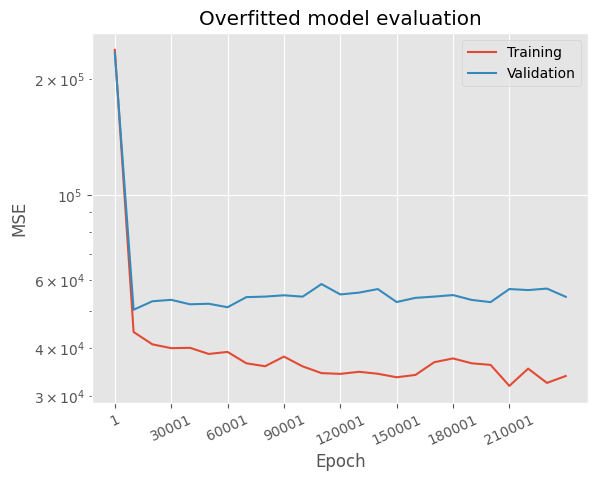

In [6]:
import matplotlib.pyplot as plt

train_losses_sampled = train_losses[::10000]  # Select every 1000th value
val_losses_sampled = val_losses[::10000]      # Select every 1000th value

# Generate corresponding epoch numbers, assuming epochs_suc is your list of epoch numbers
epochs_sampled = epochs_suc[::10000]

plt.style.use("ggplot")
plt.title("Overfitted model evaluation")


# Use sampled data for plotting
plt.plot(epochs_sampled, train_losses_sampled, label='Training')
plt.plot(epochs_sampled, val_losses_sampled, label='Validation')

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.yscale('log')
plt.xticks(
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    rotation = 25
)
plt.legend()
plt.show()
# plt.savefig("../visualizations/overfit_model_evaluation_full_dataset.png", dpi=800)